# Housekeeping

### 1.1 Load Libraries

In [1]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

#machine learning
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans 
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import operator
from functools import reduce
import random

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

### 1.2 Load data

In [3]:
#import data
old_train = pd.read_csv("C:/Users/Meyke/WiDS/data/train.csv")
old_test = pd.read_csv("C:/Users/Meyke/WiDS/data/test.csv")

In [4]:
#version 18/1/22 - imputed dataset
df = pd.read_csv("C:/Users/Meyke/WiDS/data/data_1801.csv")
df2 = pd.read_csv("C:/Users/Meyke/WiDS/data/data_1801_2.csv")
df3 = pd.read_csv("C:/Users/Meyke/WiDS/data/Submission Files/17012022_Submission_5.csv")

In [5]:
df = df.set_index('id')
df2 = df2.set_index('id')
df3 = df3.set_index('id')

In [6]:
df = pd.concat([df, df2], axis=1).reindex(df.index)

In [7]:
df = df.loc[:,~df.columns.duplicated()]

In [8]:
def diff_eui(row):
    temp_df = df[df['building_id'] ==  row.building_id]
    years = temp_df['year_factor'].to_list()
    e_star = temp_df['site_eui'].to_list()
    if len(years) > 1:
        years_2 = [x for x in years if x < row.year_factor]
        if len(years_2) > 0:
            prev_e_star = row.site_eui - e_star[years.index(max(years_2))]
        else:
            prev_e_star = 0
    else:
        prev_e_star = 0
    
    return prev_e_star

In [9]:
df['eui_diff'] = df.apply(diff_eui, axis =1)

In [10]:
df= df.reset_index()

### 1.3 Select Features and Encode (star - site_eui)

In [11]:
features_to_test = ['id', 'building_id', 'year_factor', 'state_factor', 'facility_type', 'floor_area', 'year_built_imputed', 'energy_star_function_sfg_median',
                             'heating_degree_days','cooling_degree_days', 'elevation','hdd_extreme','total_number','number_summer','number_autumn',
                    'calculated_eui','site_eui']

In [12]:
df = df[features_to_test]

In [13]:
one_hot = pd.get_dummies(df['facility_type'])
df = df.join(one_hot)

In [14]:
df.head()

,id,building_id,year_factor,state_factor,facility_type,floor_area,year_built_imputed,energy_star_function_sfg_median,heating_degree_days,cooling_degree_days,elevation,hdd_extreme,total_number,number_summer,number_autumn,calculated_eui,site_eui,2to4_Unit_Building,5plus_Unit_Building,Commercial_Other,Commercial_Unknown,Data_Center,Education_College_or_university,Education_Other_classroom,Education_Preschool_or_daycare,Education_Uncategorized,Food_Sales,Food_Service_Other,Food_Service_Restaurant_or_cafeteria,Food_Service_Uncategorized,Grocery_store_or_food_market,Health_Care_Inpatient,Health_Care_Outpatient_Clinic,Health_Care_Outpatient_Uncategorized,Health_Care_Uncategorized,Industrial,Laboratory,Lodging_Dormitory_or_fraternity_sorority,Lodging_Hotel,Lodging_Other,Lodging_Uncategorized,Mixed_Use_Commercial_and_Residential,Mixed_Use_Predominantly_Commercial,Mixed_Use_Predominantly_Residential,Multifamily_Uncategorized,Nursing_Home,Office_Bank_or_other_financial,Office_Medical_non_diagnostic,Office_Mixed_use,Office_Uncategorized,Parking_Garage,Public_Assembly_Drama_theater,Public_Assembly_Entertainment_culture,Public_Assembly_Library,Public_Assembly_Movie_Theater,Public_Assembly_Other,Public_Assembly_Recreation,Public_Assembly_Social_meeting,Public_Assembly_Stadium,Public_Assembly_Uncategorized,Public_Safety_Courthouse,Public_Safety_Fire_or_police_station,Public_Safety_Penitentiary,Public_Safety_Uncategorized,Religious_worship,Retail_Enclosed_mall,Retail_Strip_shopping_mall,Retail_Uncategorized,Retail_Vehicle_dealership_showroom,Service_Drycleaning_or_Laundry,Service_Uncategorized,Service_Vehicle_service_repair_shop,Warehouse_Distribution_or_Shipping_center,Warehouse_Nonrefrigerated,Warehouse_Refrigerated,Warehouse_Selfstorage,Warehouse_Uncategorized
0,0,313.0,1,State_1,Grocery_store_or_food_market,61242.0,1942.0,11.0,2960,115,2.4,346.734908,20836.9723,5823.49635,5101.88945,231.720532,248.682615,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,201.0,1,State_1,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,2960,115,1.8,346.734908,20836.9723,5823.49635,5101.88945,26.057054,26.500150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,463.0,1,State_1,Retail_Enclosed_mall,280025.0,1951.0,97.0,2960,115,1.8,346.734908,20836.9723,5823.49635,5101.88945,22.171559,24.693619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,303.0,1,State_1,Education_Other_classroom,55325.0,1980.0,46.0,2960,115,1.8,346.734908,20836.9723,5823.49635,5101.88945,40.891278,48.406926,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,445.0,1,State_1,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2960,115,2.4,346.734908,20836.9723,5823.49635,5101.88945,4.897449,3.899395,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


#### 1.3.1 facility_type and star (coef, intercept)

In [15]:
df['Service_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Service_Uncategorized'] == 1 else 0, axis=1)
df['Service_Vehicle_service_repair_shop'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Service_Vehicle_service_repair_shop'] == 1 else 0, axis=1)
df['Public_Safety_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Safety_Uncategorized'] == 1 else 0, axis=1)
df['Warehouse_Distribution_or_Shipping_center'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Warehouse_Distribution_or_Shipping_center'] == 1 else 0, axis=1)
df['Warehouse_Nonrefrigerated'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Warehouse_Nonrefrigerated'] == 1 else 0, axis=1)
df['Warehouse_Refrigerated'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Warehouse_Refrigerated'] == 1 else 0, axis=1)
df['Warehouse_Selfstorage'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Warehouse_Selfstorage'] == 1 else 0, axis=1)
df['Warehouse_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Warehouse_Uncategorized'] == 1 else 0, axis=1)
df['Public_Safety_Fire_or_police_station'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Safety_Fire_or_police_station'] == 1 else 0, axis=1)
df['Public_Safety_Penitentiary'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Safety_Penitentiary'] == 1 else 0, axis=1)
df['Public_Safety_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Safety_Uncategorized'] == 1 else 0, axis=1)
df['Religious_worship'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Religious_worship'] == 1 else 0, axis=1)
df['Retail_Enclosed_mall'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Retail_Enclosed_mall'] == 1 else 0, axis=1)
df['Retail_Strip_shopping_mall'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Retail_Strip_shopping_mall'] == 1 else 0, axis=1)
df['Retail_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Retail_Uncategorized'] == 1 else 0, axis=1)
df['Retail_Vehicle_dealership_showroom'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Retail_Vehicle_dealership_showroom'] == 1 else 0, axis=1)
df['Service_Drycleaning_or_Laundry'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Service_Drycleaning_or_Laundry'] == 1 else 0, axis=1)
df['Public_Assembly_Entertainment_culture'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Assembly_Entertainment_culture'] == 1 else 0, axis=1)
df['Public_Assembly_Library'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Assembly_Library'] == 1 else 0, axis=1)
df['Public_Assembly_Movie_Theater'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Assembly_Movie_Theater'] == 1 else 0, axis=1)
df['Public_Assembly_Other'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Assembly_Other'] == 1 else 0, axis=1)
df['Public_Assembly_Recreation'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Assembly_Recreation'] == 1 else 0, axis=1)
df['Public_Assembly_Social_meeting'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Assembly_Social_meeting'] == 1 else 0, axis=1)
df['Public_Assembly_Stadium'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Assembly_Stadium'] == 1 else 0, axis=1)
df['Public_Assembly_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Assembly_Uncategorized'] == 1 else 0, axis=1)
df['Public_Safety_Courthouse'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Safety_Courthouse'] == 1 else 0, axis=1)

In [16]:
df['5plus_Unit_Building'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['5plus_Unit_Building'] == 1 else 0, axis=1)
df['Commercial_Other'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Commercial_Other'] == 1 else 0, axis=1)
df['Commercial_Unknown'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Commercial_Unknown'] == 1 else 0, axis=1)
df['Data_Center'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Data_Center'] == 1 else 0, axis=1)
df['Education_College_or_university'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Education_College_or_university'] == 1 else 0, axis=1)
df['Education_Other_classroom'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Education_Other_classroom'] == 1 else 0, axis=1)
df['Education_Preschool_or_daycare'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Education_Preschool_or_daycare'] == 1 else 0, axis=1)
df['Education_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Education_Uncategorized'] == 1 else 0, axis=1)
df['Food_Sales'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Food_Sales'] == 1 else 0, axis=1)
df['Food_Service_Other'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Food_Service_Other'] == 1 else 0, axis=1)
df['Food_Service_Restaurant_or_cafeteria'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Food_Service_Restaurant_or_cafeteria'] == 1 else 0, axis=1)
df['Food_Service_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Food_Service_Uncategorized'] == 1 else 0, axis=1)
df['Grocery_store_or_food_market'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Grocery_store_or_food_market'] == 1 else 0, axis=1)
df['Health_Care_Inpatient'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Health_Care_Inpatient'] == 1 else 0, axis=1)
df['Health_Care_Outpatient_Clinic'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Health_Care_Outpatient_Clinic'] == 1 else 0, axis=1)
df['Health_Care_Outpatient_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Health_Care_Outpatient_Uncategorized'] == 1 else 0, axis=1)
df['Health_Care_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Health_Care_Uncategorized'] == 1 else 0, axis=1)
df['Industrial'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Industrial'] == 1 else 0, axis=1)
df['Laboratory'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Laboratory'] == 1 else 0, axis=1)
df['Lodging_Dormitory_or_fraternity_sorority'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Lodging_Dormitory_or_fraternity_sorority'] == 1 else 0, axis=1)
df['Lodging_Hotel'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Lodging_Hotel'] == 1 else 0, axis=1)
df['Lodging_Other'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Lodging_Other'] == 1 else 0, axis=1)
df['Lodging_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Lodging_Uncategorized'] == 1 else 0, axis=1)
df['Mixed_Use_Commercial_and_Residential'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Mixed_Use_Commercial_and_Residential'] == 1 else 0, axis=1)
df['Mixed_Use_Predominantly_Commercial'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Mixed_Use_Predominantly_Commercial'] == 1 else 0, axis=1)
df['Mixed_Use_Predominantly_Residential'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Mixed_Use_Predominantly_Residential'] == 1 else 0, axis=1)
df['Multifamily_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Multifamily_Uncategorized'] == 1 else 0, axis=1)
df['Nursing_Home'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Nursing_Home'] == 1 else 0, axis=1)
df['Office_Bank_or_other_financial'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Office_Bank_or_other_financial'] == 1 else 0, axis=1)
df['Office_Medical_non_diagnostic'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Office_Medical_non_diagnostic'] == 1 else 0, axis=1)
df['Office_Mixed_use'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Office_Mixed_use'] == 1 else 0, axis=1)
df['Office_Uncategorized'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Office_Uncategorized'] == 1 else 0, axis=1)
df['Parking_Garage'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Parking_Garage'] == 1 else 0, axis=1)
df['Public_Assembly_Drama_theater'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['Public_Assembly_Drama_theater'] == 1 else 0, axis=1)
df['2to4_Unit_Building'] = df.apply(lambda row: row.energy_star_function_sfg_median if row['2to4_Unit_Building'] == 1 else 0, axis=1)

In [17]:
facility_types = ['2to4_Unit_Building', '5plus_Unit_Building', 'Commercial_Other', 'Commercial_Unknown', 'Data_Center', 'Education_College_or_university', 'Education_Other_classroom', 'Education_Preschool_or_daycare',
 'Education_Uncategorized', 'Food_Sales', 'Food_Service_Other', 'Food_Service_Restaurant_or_cafeteria', 'Food_Service_Uncategorized', 'Grocery_store_or_food_market', 'Health_Care_Inpatient', 'Health_Care_Outpatient_Clinic',
 'Health_Care_Outpatient_Uncategorized',  'Health_Care_Uncategorized', 'Industrial', 'Laboratory', 'Lodging_Dormitory_or_fraternity_sorority', 'Lodging_Hotel', 'Lodging_Other', 'Lodging_Uncategorized',
 'Mixed_Use_Commercial_and_Residential', 'Mixed_Use_Predominantly_Commercial', 'Mixed_Use_Predominantly_Residential', 'Multifamily_Uncategorized', 'Nursing_Home', 'Office_Bank_or_other_financial',
 'Office_Medical_non_diagnostic', 'Office_Mixed_use', 'Office_Uncategorized', 'Parking_Garage', 'Public_Assembly_Drama_theater', 'Public_Assembly_Entertainment_culture', 'Public_Assembly_Library',
 'Public_Assembly_Movie_Theater', 'Public_Assembly_Other', 'Public_Assembly_Recreation', 'Public_Assembly_Social_meeting', 'Public_Assembly_Stadium', 'Public_Assembly_Uncategorized', 'Public_Safety_Courthouse',
 'Public_Safety_Fire_or_police_station', 'Public_Safety_Penitentiary', 'Religious_worship', 'Retail_Enclosed_mall', 'Retail_Strip_shopping_mall', 'Retail_Uncategorized',
 'Retail_Vehicle_dealership_showroom', 'Service_Drycleaning_or_Laundry', 'Service_Uncategorized', 'Service_Vehicle_service_repair_shop', 'Warehouse_Distribution_or_Shipping_center', 'Warehouse_Nonrefrigerated',
 'Warehouse_Refrigerated', 'Warehouse_Selfstorage', 'Warehouse_Uncategorized']

In [18]:
len(facility_types)

59

In [19]:
df[df[facility_types[0]]!=0]

,id,building_id,year_factor,state_factor,facility_type,floor_area,year_built_imputed,energy_star_function_sfg_median,heating_degree_days,cooling_degree_days,elevation,hdd_extreme,total_number,number_summer,number_autumn,calculated_eui,site_eui,2to4_Unit_Building,5plus_Unit_Building,Commercial_Other,Commercial_Unknown,Data_Center,Education_College_or_university,Education_Other_classroom,Education_Preschool_or_daycare,Education_Uncategorized,Food_Sales,Food_Service_Other,Food_Service_Restaurant_or_cafeteria,Food_Service_Uncategorized,Grocery_store_or_food_market,Health_Care_Inpatient,Health_Care_Outpatient_Clinic,Health_Care_Outpatient_Uncategorized,Health_Care_Uncategorized,Industrial,Laboratory,Lodging_Dormitory_or_fraternity_sorority,Lodging_Hotel,Lodging_Other,Lodging_Uncategorized,Mixed_Use_Commercial_and_Residential,Mixed_Use_Predominantly_Commercial,Mixed_Use_Predominantly_Residential,Multifamily_Uncategorized,Nursing_Home,Office_Bank_or_other_financial,Office_Medical_non_diagnostic,Office_Mixed_use,Office_Uncategorized,Parking_Garage,Public_Assembly_Drama_theater,Public_Assembly_Entertainment_culture,Public_Assembly_Library,Public_Assembly_Movie_Theater,Public_Assembly_Other,Public_Assembly_Recreation,Public_Assembly_Social_meeting,Public_Assembly_Stadium,Public_Assembly_Uncategorized,Public_Safety_Courthouse,Public_Safety_Fire_or_police_station,Public_Safety_Penitentiary,Public_Safety_Uncategorized,Religious_worship,Retail_Enclosed_mall,Retail_Strip_shopping_mall,Retail_Uncategorized,Retail_Vehicle_dealership_showroom,Service_Drycleaning_or_Laundry,Service_Uncategorized,Service_Vehicle_service_repair_shop,Warehouse_Distribution_or_Shipping_center,Warehouse_Nonrefrigerated,Warehouse_Refrigerated,Warehouse_Selfstorage,Warehouse_Uncategorized
69345,69345,16133.0,5,State_11,2to4_Unit_Building,25596.0,1962.0,88.0,3742,430,470.3,436.767281,20339.42945,6137.41395,4463.80585,23.704050,23.161815,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69355,69355,12390.0,5,State_11,2to4_Unit_Building,51098.0,1957.0,45.0,3742,430,18.3,436.767281,20339.42945,6137.41395,4463.80585,34.474470,31.511974,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69356,69356,16456.0,5,State_11,2to4_Unit_Building,31457.0,1979.0,95.0,3742,430,18.3,436.767281,20339.42945,6137.41395,4463.80585,17.899395,18.148913,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69357,69357,12253.0,5,State_11,2to4_Unit_Building,115819.0,1967.0,1.0,3742,430,18.3,436.767281,20339.42945,6137.41395,4463.80585,30.460123,29.031765,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69390,69390,16792.0,5,State_11,2to4_Unit_Building,28260.0,1914.0,77.0,3742,430,18.3,436.767281,20339.42945,6137.41395,4463.80585,81.153093,81.525575,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

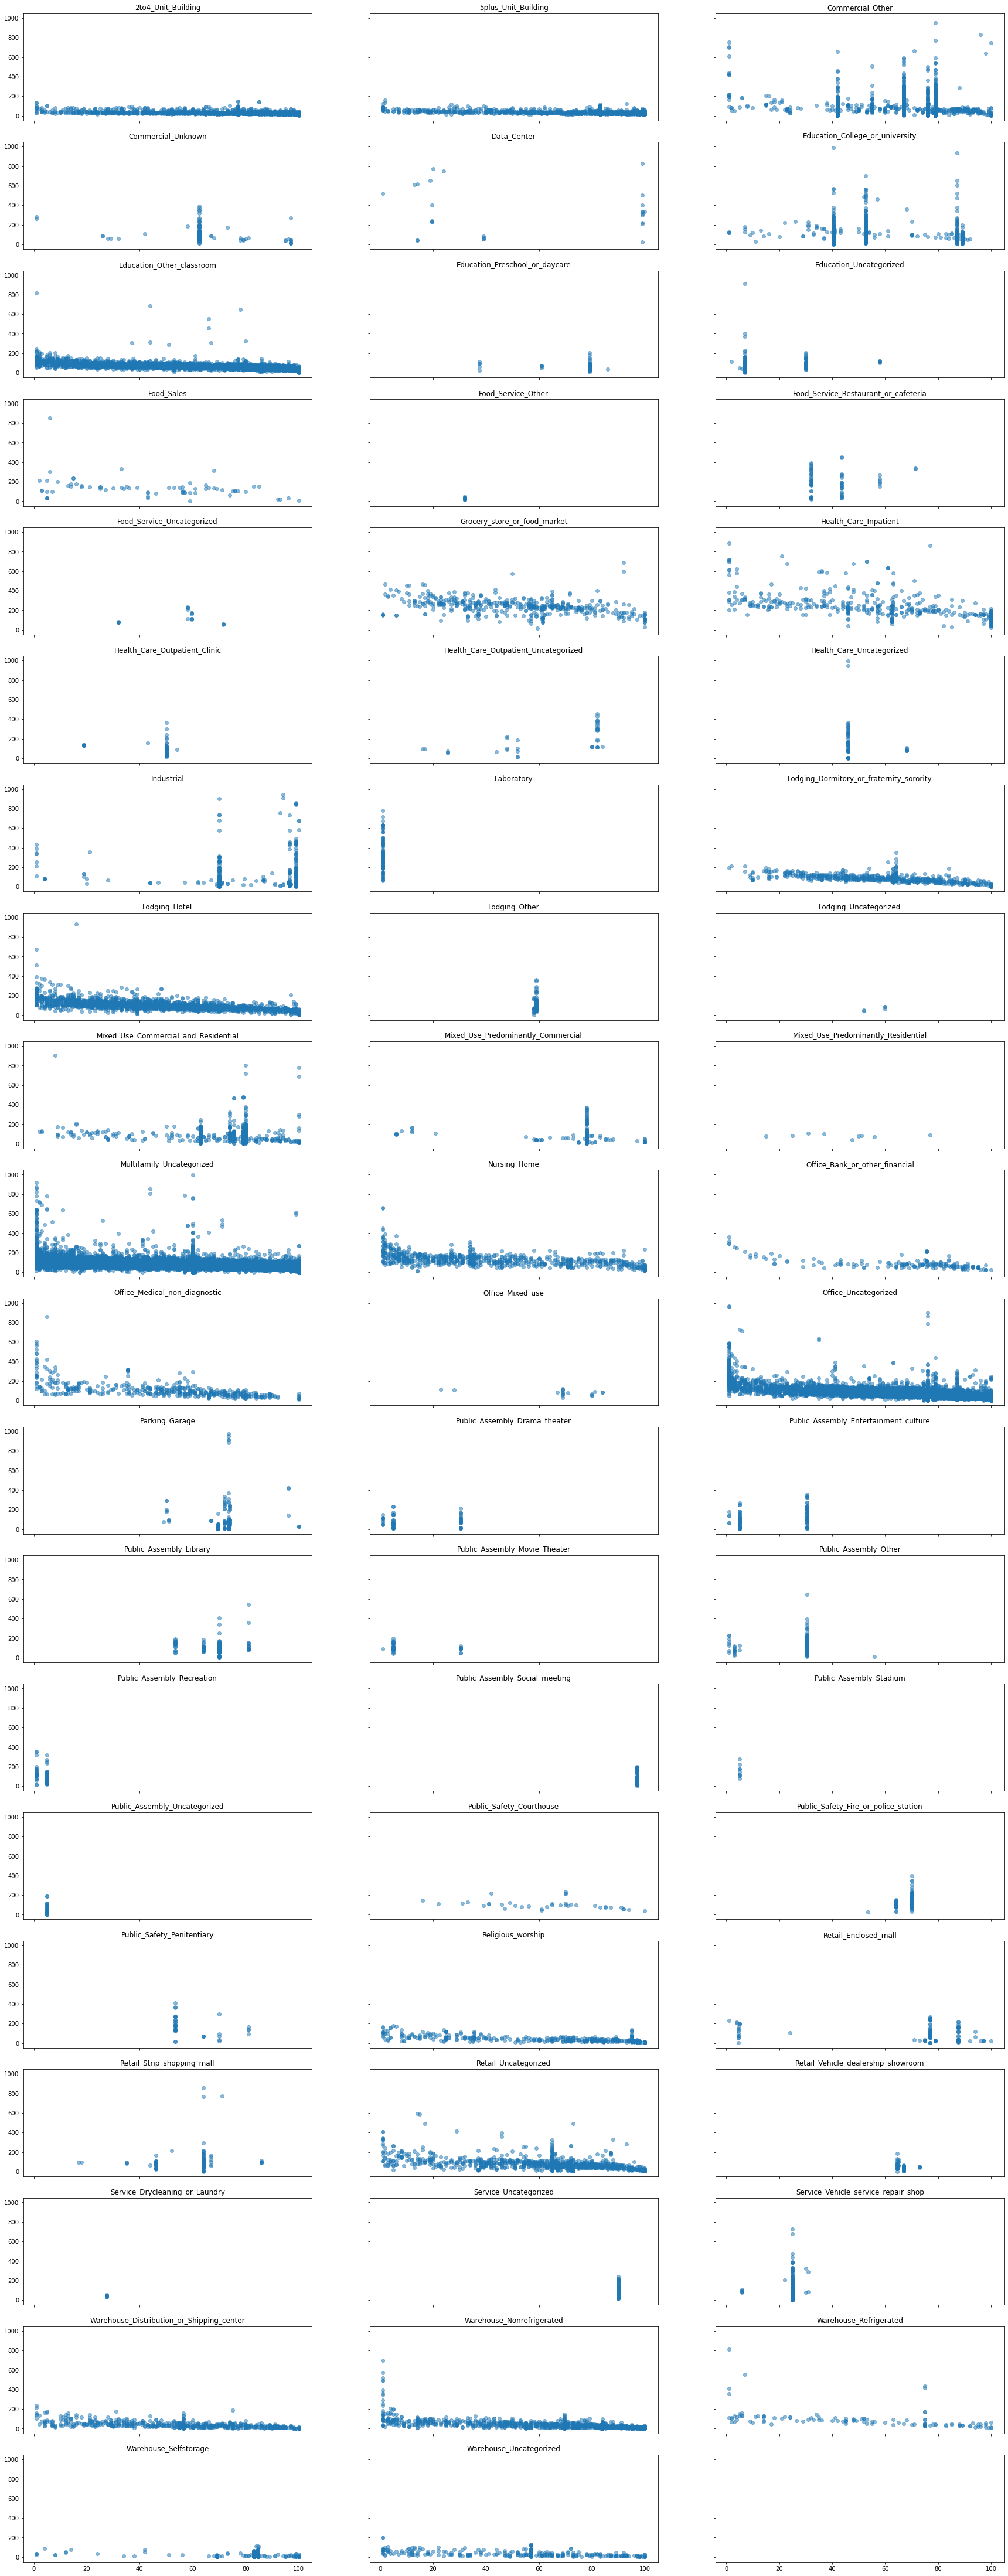

In [20]:
f = plt.figure()    
f, axes = plt.subplots(nrows = 20, ncols = 3, sharex=True, sharey = True,figsize=(30,80))

list_value = 0

for x in range(20):
    for y in range(3):
        axes[x][y].scatter(df[df[facility_types[list_value]]!=0][facility_types[list_value]],df[df[facility_types[list_value]]!=0]['site_eui'], alpha=0.5)
        axes[x][y].set_title(facility_types[list_value])
        list_value += 1

plt.show();

In [21]:
facility_types_uncorrelated = ['Commercial_Unknown','Data_Center','Education_Preschool_or_daycare','Education_Uncategorized','Food_Service_Other',
 'Food_Service_Restaurant_or_cafeteria', 'Food_Service_Uncategorized', 'Health_Care_Outpatient_Clinic',
 'Health_Care_Outpatient_Uncategorized', 'Health_Care_Uncategorized','Laboratory','Lodging_Other','Lodging_Uncategorized',
 'Mixed_Use_Predominantly_Residential', 'Office_Mixed_use','Parking_Garage','Public_Assembly_Drama_theater',
 'Public_Assembly_Entertainment_culture','Public_Assembly_Library','Public_Assembly_Movie_Theater','Public_Assembly_Other',
 'Public_Assembly_Recreation','Public_Assembly_Social_meeting','Public_Assembly_Stadium', 'Public_Assembly_Uncategorized','Public_Safety_Fire_or_police_station',
 'Public_Safety_Penitentiary', 'Public_Safety_Uncategorized','Retail_Enclosed_mall','Retail_Strip_shopping_mall','Retail_Vehicle_dealership_showroom',
 'Service_Drycleaning_or_Laundry','Service_Uncategorized','Service_Vehicle_service_repair_shop']

facility_types_correlated = ['2to4_Unit_Building', '5plus_Unit_Building','Commercial_Other', 'Education_College_or_university', 'Education_Other_classroom',
 'Food_Sales', 'Grocery_store_or_food_market', 'Health_Care_Inpatient', 'Industrial', 'Lodging_Dormitory_or_fraternity_sorority',
 'Lodging_Hotel', 'Mixed_Use_Commercial_and_Residential', 'Mixed_Use_Predominantly_Commercial', 'Multifamily_Uncategorized',
 'Nursing_Home', 'Office_Bank_or_other_financial', 'Office_Medical_non_diagnostic', 'Office_Uncategorized', 'Public_Safety_Courthouse',
 'Religious_worship', 'Retail_Uncategorized', 'Warehouse_Distribution_or_Shipping_center', 'Warehouse_Nonrefrigerated',
 'Warehouse_Refrigerated', 'Warehouse_Selfstorage', 'Warehouse_Uncategorized']

In [22]:
coef_L = []
intercept_L = []

for x in range(len(facility_types)):
    X, Y = df[(df[facility_types[x]]!=0) & (df['site_eui'] == df['site_eui'])][facility_types[x]].values.reshape(-1, 1), df[(df[facility_types[x]]!=0)  & (df['site_eui'] == df['site_eui'])]['site_eui'].values.reshape(-1, 1)
    coef = LinearRegression().fit(X, Y).coef_
    intercept = LinearRegression().fit(X, Y).intercept_
    coef_L.append(coef[0])
    intercept_L.append(intercept)

In [23]:
df_F_type = pd.DataFrame(list(zip(coef_L, intercept_L)), columns =['coef', 'intercept'], dtype = float)
df_F_type['types'] = facility_types
df_F_type.set_index('types')

,coef,intercept
types,,
2to4_Unit_Building,-0.256426,50.060824
5plus_Unit_Building,-0.306002,59.131816
Commercial_Other,-0.823360,149.468756
Commercial_Unknown,-1.460514,207.201055
Data_Center,-0.442063,363.360674
Education_College_or_university,-0.419412,132.030808
Education_Other_classroom,-0.634853,108.514667
Education_Preschool_or_daycare,-0.436375,94.346787
Education_Uncategorized,1.915099,29.614891


In [24]:
mean_eui = df.groupby(['facility_type'])['site_eui'].mean()
mean_eui = mean_eui.to_frame()

In [25]:
df_F_type = df_F_type.set_index('types')

In [26]:
df_F_type = pd.concat([df_F_type, mean_eui], axis=1).reindex(df_F_type.index)

In [27]:
df_F_type['intercept_log'] = np.log10(df_F_type['intercept']+4000)

In [28]:
df_F_type['eui_log'] = np.log10(df_F_type['site_eui'])

In [29]:
df_F_type[['coef']].sort_values(by='coef')

,coef
types,
Public_Assembly_Recreation,-10.524359
Retail_Vehicle_dealership_showroom,-5.829589
Health_Care_Uncategorized,-4.948922
Public_Safety_Penitentiary,-3.793913
Health_Care_Inpatient,-2.395729
Office_Medical_non_diagnostic,-2.049428
Commercial_Unknown,-1.460514
Office_Bank_or_other_financial,-1.460328
Warehouse_Refrigerated,-1.415431


In [30]:
df_F_type

,coef,intercept,site_eui,intercept_log,eui_log
types,,,,,
2to4_Unit_Building,-0.256426,50.060824,31.876915,3.607462,1.503476
5plus_Unit_Building,-0.306002,59.131816,36.737785,3.608433,1.565113
Commercial_Other,-0.823360,149.468756,92.642037,3.617992,1.966808
Commercial_Unknown,-1.460514,207.201055,113.151628,3.623993,2.053661
Data_Center,-0.442063,363.360674,339.734876,3.639821,2.531140
Education_College_or_university,-0.419412,132.030808,108.629116,3.616164,2.035946
Education_Other_classroom,-0.634853,108.514667,69.441531,3.613685,1.841619
Education_Preschool_or_daycare,-0.436375,94.346787,60.974215,3.612185,1.785146
Education_Uncategorized,1.915099,29.614891,46.172799,3.605264,1.664386


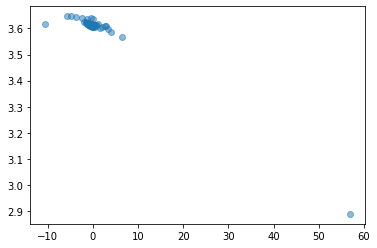

In [31]:
plt.scatter(df_F_type['coef'], df_F_type['intercept_log'], alpha=0.5)

#### 1.3.2 cluster commercial

In [71]:
# import data
old_train = pd.read_csv("C:/Users/Meyke/WiDS/data/train.csv")
old_test = pd.read_csv("C:/Users/Meyke/WiDS/data/test.csv")

#
df = pd.read_csv("C:/Users/Meyke/WiDS/data/features_data_2801_imputed_star_rating_and_generous_building_id.csv")
df = df.set_index('id')

del df['Unnamed: 0']

#rename
df.head()

,year_factor,state_factor,building_class,facility_type,floor_area,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,...,days_with_fog,site_eui,building_id,energy_star_rating,peak_NE,peak_SE,peak_SW,peak_NW,max_NE,max_SE,max_SW,max_NW,facility_group,year_built,floor_area_binned,energy_intensity_floor_area,energy_intensity_built_year,energy_intensity_facility_type,mean_energy_rating_building_id,number_january,number_february,number_march,number_april,number_may,number_june,number_july,number_august,number_september,number_october,number_november,number_december,total_number,number_winter,number_spring,number_summer,number_autumn,eui_improved,eui_diff,hdd_extreme,hdd_extreme_2,avg_total_number_building,avg_eui_building,year_built_bin,yearB_E_int,calculated_eui,calc_eui_perc_off,binned_calc_eui,binned_calc_eui_20,verschil_uitstoot_per_temp_tov_jaar_state,StateYear_E_Int
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,0.0,248.682615,313,11.0,1,0,0,0,1,0,0,0,food_sales_service,1942.0,1,3,3,2,29.0,1566.55555,1418.66785,1668.93785,1667.724,1768.23175,1821.4695,1948.21145,1931.46055,1943.82435,1954.89605,1616.5197,1530.4737,20836.9723,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,245.522877,2,3,231.720532,-0.068208,10,10,0.856815,3
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,12.0,26.500150,201,45.0,0,0,0,0,1,0,0,0,distribution_shipping,1955.0,4,1,1,2,40.6,1566.55555,1418.66785,1668.93785,1667.724,1768.23175,1821.4695,1948.21145,1931.46055,1943.82435,1954.89605,1616.5197,1530.4737,20836.9723,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,27.609132,3,2,26.057054,-0.016720,1,1,-0.209475,2
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,12.0,24.693619,463,97.0,0,0,0,0,1,0,0,0,retail,1951.0,4,1,1,2,97.8,1566.55555,1418.66785,1668.93785,1667.724,1768.23175,1821.4695,1948.21145,1931.46055,1943.82435,1954.89605,1616.5197,1530.4737,20836.9723,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22068.147067,23.481589,3,2,22.171559,-0.102134,1,1,-0.218145,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,12.0,48.406926,303,46.0,0,0,0,0,1,0,0,0,eduation,1980.0,1,2,2,1,49.1,1566.55555,1418.66785,1668.93785,1667.724,1768.23175,1821.4695,1948.21145,1931.46055,1943.82435,1954.89605,1616.5197,1530.4737,20836.972

In [72]:
df = df.reset_index()
#split into (new) train 

df

,id,year_factor,state_factor,building_class,facility_type,floor_area,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,...,days_with_fog,site_eui,building_id,energy_star_rating,peak_NE,peak_SE,peak_SW,peak_NW,max_NE,max_SE,max_SW,max_NW,facility_group,year_built,floor_area_binned,energy_intensity_floor_area,energy_intensity_built_year,energy_intensity_facility_type,mean_energy_rating_building_id,number_january,number_february,number_march,number_april,number_may,number_june,number_july,number_august,number_september,number_october,number_november,number_december,total_number,number_winter,number_spring,number_summer,number_autumn,eui_improved,eui_diff,hdd_extreme,hdd_extreme_2,avg_total_number_building,avg_eui_building,year_built_bin,yearB_E_int,calculated_eui,calc_eui_perc_off,binned_calc_eui,binned_calc_eui_20,verschil_uitstoot_per_temp_tov_jaar_state,StateYear_E_Int
0,0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,0.0,248.682615,313,11.0,1,0,0,0,1,0,0,0,food_sales_service,1942.0,1,3,3,2,29.0,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,245.522877,2,3,231.720532,-0.068208,10,10,0.856815,3
1,1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,12.0,26.500150,201,45.0,0,0,0,0,1,0,0,0,distribution_shipping,1955.0,4,1,1,2,40.6,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,27.609132,3,2,26.057054,-0.016720,1,1,-0.209475,2
2,2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,12.0,24.693619,463,97.0,0,0,0,0,1,0,0,0,retail,1951.0,4,1,1,2,97.8,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22068.147067,23.481589,3,2,22.171559,-0.102134,1,1,-0.218145,2
3,3,1,State_1,Commercial,Education_Other_classroom,55325.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,12.0,48.406926,303,46.0,0,0,0,0,1,0,0,0,eduation,1980.0,1,2,2,1,49.1,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,46

In [73]:
df = df[df['building_class'] == "Commercial"]

In [74]:
df

,id,year_factor,state_factor,building_class,facility_type,floor_area,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,...,days_with_fog,site_eui,building_id,energy_star_rating,peak_NE,peak_SE,peak_SW,peak_NW,max_NE,max_SE,max_SW,max_NW,facility_group,year_built,floor_area_binned,energy_intensity_floor_area,energy_intensity_built_year,energy_intensity_facility_type,mean_energy_rating_building_id,number_january,number_february,number_march,number_april,number_may,number_june,number_july,number_august,number_september,number_october,number_november,number_december,total_number,number_winter,number_spring,number_summer,number_autumn,eui_improved,eui_diff,hdd_extreme,hdd_extreme_2,avg_total_number_building,avg_eui_building,year_built_bin,yearB_E_int,calculated_eui,calc_eui_perc_off,binned_calc_eui,binned_calc_eui_20,verschil_uitstoot_per_temp_tov_jaar_state,StateYear_E_Int
0,0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,0.0,248.682615,313,11.0,1,0,0,0,1,0,0,0,food_sales_service,1942.0,1,3,3,2,29.0,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,245.522877,2,3,231.720532,-0.068208,10,10,0.856815,3
1,1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,12.0,26.500150,201,45.0,0,0,0,0,1,0,0,0,distribution_shipping,1955.0,4,1,1,2,40.6,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,27.609132,3,2,26.057054,-0.016720,1,1,-0.209475,2
2,2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,12.0,24.693619,463,97.0,0,0,0,0,1,0,0,0,retail,1951.0,4,1,1,2,97.8,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22068.147067,23.481589,3,2,22.171559,-0.102134,1,1,-0.218145,2
3,3,1,State_1,Commercial,Education_Other_classroom,55325.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,12.0,48.406926,303,46.0,0,0,0,0,1,0,0,0,eduation,1980.0,1,2,2,1,49.1,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,46

In [75]:
#split into (new) train and test set based on id
df_train = df[df["id"].isin(old_train["id"])]
df_test = df[df["id"].isin(old_test["id"])]

In [76]:
# Encode Categorical Columns 
cat_cols = [cname for cname in df.columns if df[cname].dtype == "object"]

for col in cat_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])

<ipython-input-76-5592173b5e3a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col] = le.fit_transform(df_train[col])
<ipython-input-76-5592173b5e3a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = le.fit_transform(df_test[col])


In [77]:
df = df_train.append(df_test)

In [78]:
#del df['index']

In [79]:
df.head()

,id,year_factor,state_factor,building_class,facility_type,floor_area,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,...,days_with_fog,site_eui,building_id,energy_star_rating,peak_NE,peak_SE,peak_SW,peak_NW,max_NE,max_SE,max_SW,max_NW,facility_group,year_built,floor_area_binned,energy_intensity_floor_area,energy_intensity_built_year,energy_intensity_facility_type,mean_energy_rating_building_id,number_january,number_february,number_march,number_april,number_may,number_june,number_july,number_august,number_september,number_october,number_november,number_december,total_number,number_winter,number_spring,number_summer,number_autumn,eui_improved,eui_diff,hdd_extreme,hdd_extreme_2,avg_total_number_building,avg_eui_building,year_built_bin,yearB_E_int,calculated_eui,calc_eui_perc_off,binned_calc_eui,binned_calc_eui_20,verschil_uitstoot_per_temp_tov_jaar_state,StateYear_E_Int
0,0,1,0,0,11,61242.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,0.0,248.682615,313,11.0,1,0,0,0,1,0,0,0,3,1942.0,1,3,3,2,29.0,1566.55555,1418.66785,1668.93785,1667.724,1768.23175,1821.4695,1948.21145,1931.46055,1943.82435,1954.89605,1616.5197,1530.4737,20836.9723,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,245.522877,2,3,231.720532,-0.068208,10,10,0.856815,3
1,1,1,0,0,49,274000.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,12.0,26.500150,201,45.0,0,0,0,0,1,0,0,0,1,1955.0,4,1,1,2,40.6,1566.55555,1418.66785,1668.93785,1667.724,1768.23175,1821.4695,1948.21145,1931.46055,1943.82435,1954.89605,1616.5197,1530.4737,20836.9723,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,27.609132,3,2,26.057054,-0.016720,1,1,-0.209475,2
2,2,1,0,0,42,280025.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,12.0,24.693619,463,97.0,0,0,0,0,1,0,0,0,12,1951.0,4,1,1,2,97.8,1566.55555,1418.66785,1668.93785,1667.724,1768.23175,1821.4695,1948.21145,1931.46055,1943.82435,1954.89605,1616.5197,1530.4737,20836.9723,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22068.147067,23.481589,3,2,22.171559,-0.102134,1,1,-0.218145,2
3,3,1,0,0,4,55325.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,...,12.0,48.406926,303,46.0,0,0,0,0,1,0,0,0,2,1980.0,1,2,2,1,49.1,1566.55555,1418.66785,1668.93785,1667.724,1768.23175,1821.4695,1948.21145,1931.46055,1943.82435,1954.89605,1616.5197,1530.4737,20836.9723,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22050.354236,43.272466,4,2,40.891278,-0.155260,2,2,-0.104341,2
4,4,1,0,0,50,66000.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,1

In [80]:
features_for_cluster =  ['id','energy_star_rating','floor_area','verschil_uitstoot_per_temp_tov_jaar_state', 'year_built','total_number']

In [81]:
df = df[features_for_cluster]

In [83]:
df = df.set_index('id')

In [86]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [87]:
df =normalize(df)

In [88]:
df

,energy_star_rating,floor_area,verschil_uitstoot_per_temp_tov_jaar_state,year_built,total_number
id,,,,,
0,0.091837,0.009445,0.277570,0.822115,0.384041
1,0.438776,0.042769,0.064819,0.853365,0.384041
2,0.969388,0.043713,0.063089,0.843750,0.384041
3,0.448980,0.008518,0.085796,0.913462,0.384041
4,1.000000,0.010190,0.043177,0.925481,0.384041
...,...,...,...,...,...
85115,0.010204,0.004864,0.120066,0.879808,0.273156
85116,0.806122,0.006115,0.079123,0.855769,0.273156
85117,0.566327,0.007209,0.071185,0.836538,0.273156


In [89]:
df = df.reset_index()

In [91]:
#split into (new) train and test set based on id
df_train = df[df["id"].isin(old_train["id"])]
df_test = df[df["id"].isin(old_test["id"])]

In [93]:
df_train = df_train.set_index('id')
df_test = df_test.set_index('id')

Text(0.5, 0, 'B')

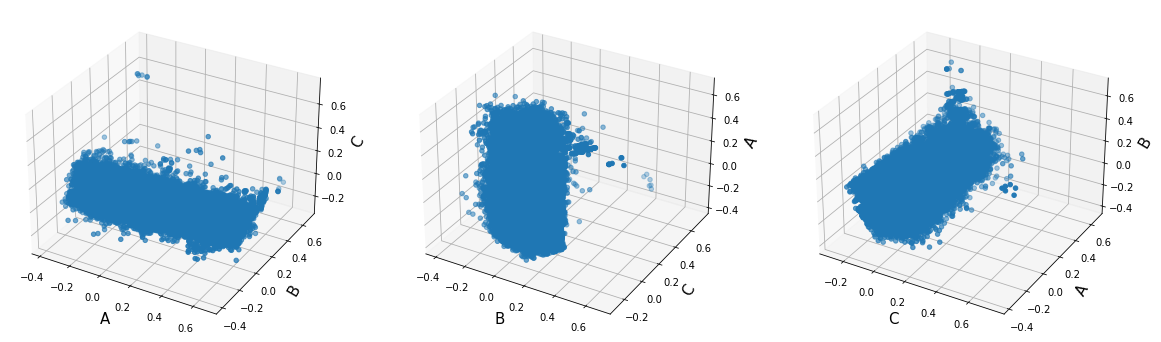

In [97]:
plt.rcParams["figure.figsize"] = (7,7)

#PCA
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
PC=pca.fit_transform(df_train)
PC_test=pca.transform(df_test)

PC = np.concatenate([PC, PC_test])

pdf=pd.DataFrame(data=PC,columns=['A','B','C'])
#sns.scatterplot(data=pdf, x="A", y="B", hue="C")

fig = plt.figure(figsize=(20,9))
ax = fig.add_subplot(131, projection='3d')
sc = ax.scatter(pdf['A'],pdf['B'],pdf['C'],
                cmap='cool')
ax.set_xlabel("A", fontsize=15)
ax.set_ylabel("B", fontsize=15, rotation=60)
ax.set_zlabel("C", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

ax = fig.add_subplot(132, projection='3d')
sc = ax.scatter(pdf['B'],pdf['C'],pdf['A'],
                cmap='cool')
ax.set_xlabel("B", fontsize=15)
ax.set_ylabel("C", fontsize=15, rotation=60)
ax.set_zlabel("A", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

ax = fig.add_subplot(133, projection='3d')
sc = ax.scatter(pdf['C'],pdf['A'],pdf['B'],
                cmap='cool')
ax.set_xlabel("C", fontsize=15)
ax.set_ylabel("A", fontsize=15, rotation=60)
ax.set_zlabel("B", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

In [102]:
pdf['id'] = df['id'].to_list()
pdf

,A,B,C,id
0,0.554203,0.028574,0.002640,0
1,0.190251,0.022976,-0.001759,1
2,-0.338398,0.017433,-0.015204,2
3,0.184279,-0.004091,-0.055764,3
4,-0.367709,-0.016660,-0.081231,4
...,...,...,...,...
37801,0.623000,-0.078486,0.039627,85115
37802,-0.173676,-0.078656,0.034435,85116
37803,0.063736,-0.064262,0.062049,85117
37804,-0.224776,-0.092114,0.011479,85118


In [103]:
pdf = pdf.set_index('id')

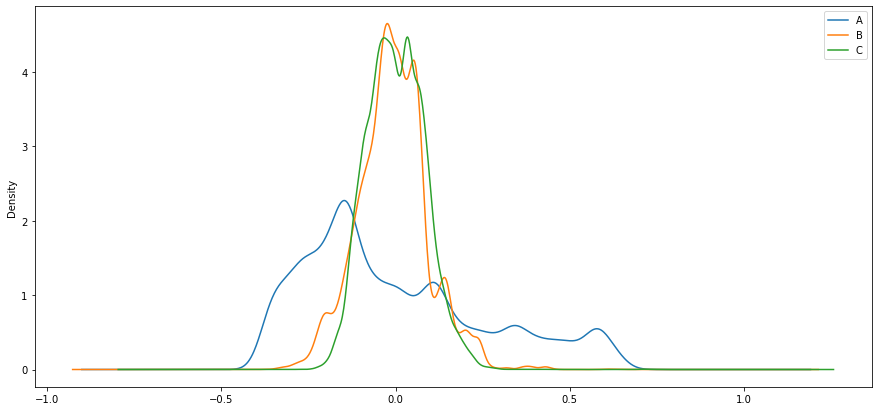

In [104]:
plt.rcParams["figure.figsize"] = (15,7)
pdf.plot.density()
plt.show()

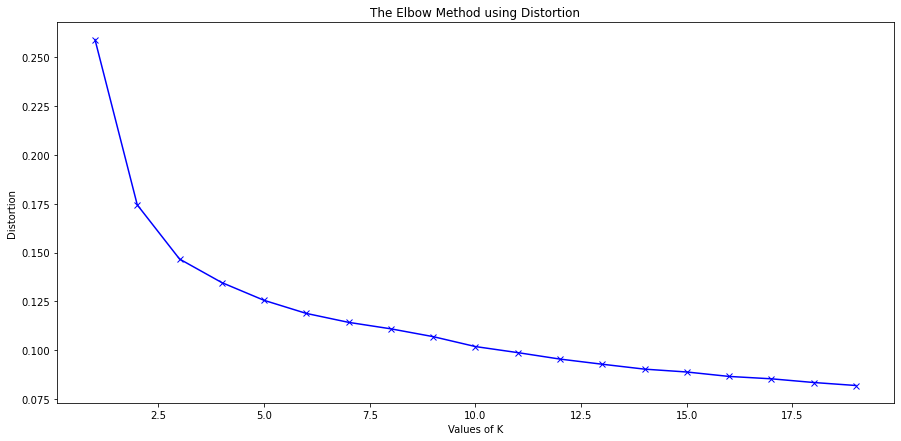

In [100]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(pdf)
    kmeanModel.fit(pdf)
 
    distortions.append(sum(np.min(cdist(pdf, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / pdf.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(pdf, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / pdf.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [105]:
pdf = pdf.reset_index()

#split into (new) train and test set based on id
pdf_train = pdf[pdf["id"].isin(old_train["id"])]
pdf_test = pdf[pdf["id"].isin(old_test["id"])]

In [111]:
pdf_train = pdf_train.set_index('id')

In [113]:
pdf_test = pdf_test.set_index('id')

In [116]:
pdf = pdf.set_index('id')

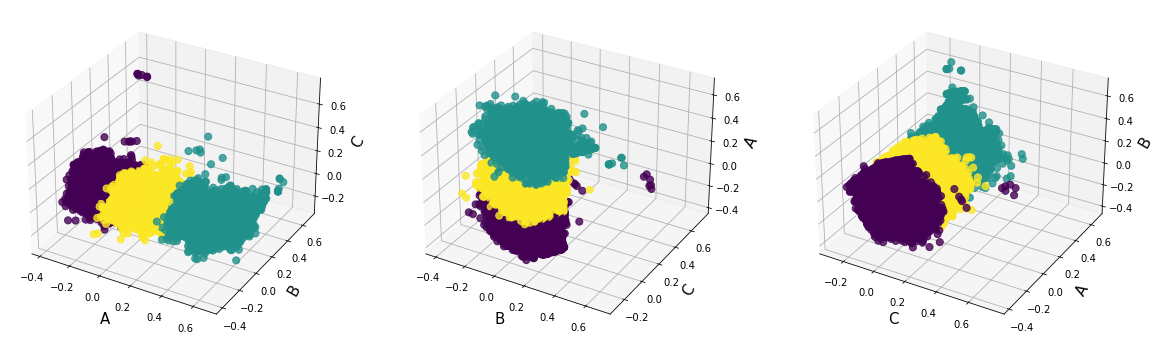

In [117]:
#Kmeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3).fit(pdf_train)
y_kmeans=km.predict(pdf)

fig = plt.figure(figsize=(20,9))
ax = fig.add_subplot(131, projection='3d')
sc = ax.scatter(pdf['A'],pdf['B'],pdf['C'],
                c=y_kmeans, s=50, alpha=0.8)
ax.set_xlabel("A", fontsize=15)
ax.set_ylabel("B", fontsize=15, rotation=60)
ax.set_zlabel("C", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

ax = fig.add_subplot(132, projection='3d')
sc = ax.scatter(pdf['B'],pdf['C'],pdf['A'],
                c=y_kmeans, s=50, alpha=0.8)
ax.set_xlabel("B", fontsize=15)
ax.set_ylabel("C", fontsize=15, rotation=60)
ax.set_zlabel("A", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

ax = fig.add_subplot(133, projection='3d')
sc = ax.scatter(pdf['C'],pdf['A'],pdf['B'],
                c=y_kmeans, s=50, alpha=0.8)
ax.set_xlabel("C", fontsize=15)
ax.set_ylabel("A", fontsize=15, rotation=60)
ax.set_zlabel("B", fontsize=15, rotation=60);
#plt.title('CoDisp above 99.5th percentile')

In [118]:
pdf['cluster_3'] = y_kmeans
pdf

,A,B,C,cluster_3
id,,,,
0,0.554203,0.028574,0.002640,1
1,0.190251,0.022976,-0.001759,2
2,-0.338398,0.017433,-0.015204,0
3,0.184279,-0.004091,-0.055764,2
4,-0.367709,-0.016660,-0.081231,0
...,...,...,...,...
85115,0.623000,-0.078486,0.039627,1
85116,-0.173676,-0.078656,0.034435,0
85117,0.063736,-0.064262,0.062049,2


In [133]:
pdf = pdf.reset_index()

In [134]:
pdf

,id,A,B,C,cluster_3
0,0,0.554203,0.028574,0.002640,1
1,1,0.190251,0.022976,-0.001759,2
2,2,-0.338398,0.017433,-0.015204,0
3,3,0.184279,-0.004091,-0.055764,2
4,4,-0.367709,-0.016660,-0.081231,0
...,...,...,...,...,...
37801,85115,0.623000,-0.078486,0.039627,1
37802,85116,-0.173676,-0.078656,0.034435,0
37803,85117,0.063736,-0.064262,0.062049,2
37804,85118,-0.224776,-0.092114,0.011479,0


In [119]:
#
df = pd.read_csv("C:/Users/Meyke/WiDS/data/features_data_2801_imputed_star_rating_and_generous_building_id.csv")
df = df.set_index('id')

del df['Unnamed: 0']

In [139]:
df['commercial_cluster'] = df.apply(lambda row: pdf[pdf['id'] == row.name]['cluster_3'].values[0] if row.name in pdf['id'].to_list() else np.nan, axis=1)

In [140]:
df['commercial_cluster'].notna().sum()

37806

In [141]:
df_original = df.copy()

In [142]:
df_original

,year_factor,state_factor,building_class,facility_type,floor_area,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,...,site_eui,building_id,energy_star_rating,peak_NE,peak_SE,peak_SW,peak_NW,max_NE,max_SE,max_SW,max_NW,facility_group,year_built,floor_area_binned,energy_intensity_floor_area,energy_intensity_built_year,energy_intensity_facility_type,mean_energy_rating_building_id,number_january,number_february,number_march,number_april,number_may,number_june,number_july,number_august,number_september,number_october,number_november,number_december,total_number,number_winter,number_spring,number_summer,number_autumn,eui_improved,eui_diff,hdd_extreme,hdd_extreme_2,avg_total_number_building,avg_eui_building,year_built_bin,yearB_E_int,calculated_eui,calc_eui_perc_off,binned_calc_eui,binned_calc_eui_20,verschil_uitstoot_per_temp_tov_jaar_state,StateYear_E_Int,commercial_cluster
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,248.682615,313,11.0,1,0,0,0,1,0,0,0,food_sales_service,1942.0,1,3,3,2,29.0,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,245.522877,2,3,231.720532,-0.068208,10,10,0.856815,3,1.0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,26.500150,201,45.0,0,0,0,0,1,0,0,0,distribution_shipping,1955.0,4,1,1,2,40.6,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,27.609132,3,2,26.057054,-0.016720,1,1,-0.209475,2,2.0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,24.693619,463,97.0,0,0,0,0,1,0,0,0,retail,1951.0,4,1,1,2,97.8,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22068.147067,23.481589,3,2,22.171559,-0.102134,1,1,-0.218145,2,0.0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,48.406926,303,46.0,0,0,0,0,1,0,0,0,eduation,1980.0,1,2,2,1,49.1,1566.55555,1418.66785,1668.937

#### 1.3.3 cluster residential

In [143]:
# import data
old_train = pd.read_csv("C:/Users/Meyke/WiDS/data/train.csv")
old_test = pd.read_csv("C:/Users/Meyke/WiDS/data/test.csv")

#
df = pd.read_csv("C:/Users/Meyke/WiDS/data/features_data_2801_imputed_star_rating_and_generous_building_id.csv")
df = df.set_index('id')

del df['Unnamed: 0']

df = df.reset_index()
#split into (new) train 

df = df[df['building_class'] == "Residential"]

#split into (new) train and test set based on id
df_train = df[df["id"].isin(old_train["id"])]
df_test = df[df["id"].isin(old_test["id"])]

# Encode Categorical Columns 
cat_cols = [cname for cname in df.columns if df[cname].dtype == "object"]

for col in cat_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])

df = df_train.append(df_test)

features_for_cluster =  ['id','energy_star_rating','floor_area','verschil_uitstoot_per_temp_tov_jaar_state', 'year_built','total_number']

df = df[features_for_cluster]

df = df.set_index('id')

df =normalize(df)

df = df.reset_index()

#split into (new) train and test set based on id
df_train = df[df["id"].isin(old_train["id"])]
df_test = df[df["id"].isin(old_test["id"])]

df_train = df_train.set_index('id')
df_test = df_test.set_index('id')

<ipython-input-143-3b5833bf4459>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col] = le.fit_transform(df_train[col])
<ipython-input-143-3b5833bf4459>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = le.fit_transform(df_test[col])


In [144]:
df_train

,energy_star_rating,floor_area,verschil_uitstoot_per_temp_tov_jaar_state,year_built,total_number
id,,,,,
18,0.775510,0.045192,0.094567,0.722071,0.628132
20,0.775510,0.108635,0.111774,0.683924,0.628132
48,0.826531,0.162803,0.116983,0.961853,0.628132
61,0.744898,0.049837,0.048709,0.787466,0.628132
62,1.000000,0.099724,0.051600,0.683924,0.628132
...,...,...,...,...,...
75743,0.979592,0.017385,0.082516,0.997275,0.519880
75746,0.755102,0.055013,0.136249,0.708447,0.519880
75751,0.785714,0.013325,0.120975,0.760218,0.519880


Text(0.5, 0, 'B')

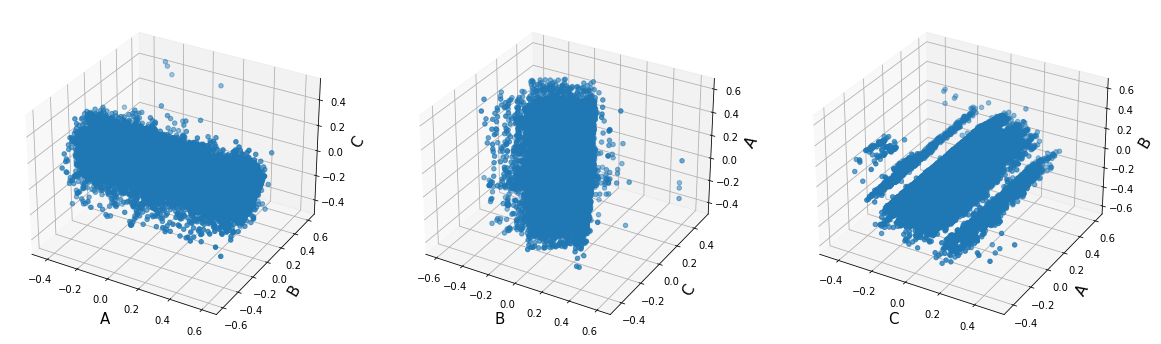

In [145]:
plt.rcParams["figure.figsize"] = (7,7)

#PCA
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
PC=pca.fit_transform(df_train)
PC_test=pca.transform(df_test)

PC = np.concatenate([PC, PC_test])

pdf=pd.DataFrame(data=PC,columns=['A','B','C'])
#sns.scatterplot(data=pdf, x="A", y="B", hue="C")

fig = plt.figure(figsize=(20,9))
ax = fig.add_subplot(131, projection='3d')
sc = ax.scatter(pdf['A'],pdf['B'],pdf['C'],
                cmap='cool')
ax.set_xlabel("A", fontsize=15)
ax.set_ylabel("B", fontsize=15, rotation=60)
ax.set_zlabel("C", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

ax = fig.add_subplot(132, projection='3d')
sc = ax.scatter(pdf['B'],pdf['C'],pdf['A'],
                cmap='cool')
ax.set_xlabel("B", fontsize=15)
ax.set_ylabel("C", fontsize=15, rotation=60)
ax.set_zlabel("A", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

ax = fig.add_subplot(133, projection='3d')
sc = ax.scatter(pdf['C'],pdf['A'],pdf['B'],
                cmap='cool')
ax.set_xlabel("C", fontsize=15)
ax.set_ylabel("A", fontsize=15, rotation=60)
ax.set_zlabel("B", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

In [146]:
pdf['id'] = df['id'].to_list()
pdf

,A,B,C,id
0,-0.198837,0.106100,0.010076,18
1,-0.196477,0.100427,0.016403,20
2,-0.240438,-0.116695,-0.134740,48
3,-0.169719,0.058238,-0.023430,61
4,-0.424268,0.095429,0.016496,62
...,...,...,...,...
47651,-0.403689,-0.250436,0.028491,85457
47652,-0.362302,0.010451,0.197623,85458
47653,-0.356147,-0.182597,0.054324,85459
47654,-0.205263,-0.133398,0.087446,85460


In [147]:
pdf = pdf.set_index('id')

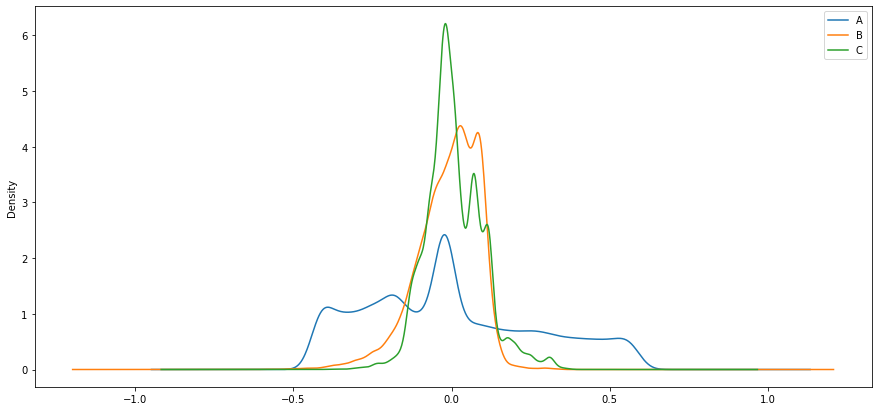

In [148]:
plt.rcParams["figure.figsize"] = (15,7)
pdf.plot.density()
plt.show()

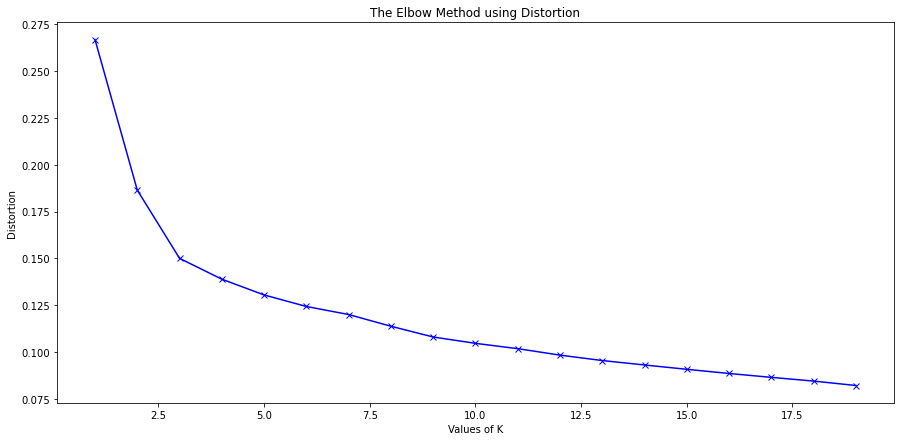

In [149]:

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(pdf)
    kmeanModel.fit(pdf)
 
    distortions.append(sum(np.min(cdist(pdf, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / pdf.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(pdf, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / pdf.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [150]:
pdf = pdf.reset_index()

#split into (new) train and test set based on id
pdf_train = pdf[pdf["id"].isin(old_train["id"])]
pdf_test = pdf[pdf["id"].isin(old_test["id"])]

pdf_train = pdf_train.set_index('id')
pdf_test = pdf_test.set_index('id')
pdf = pdf.set_index('id')


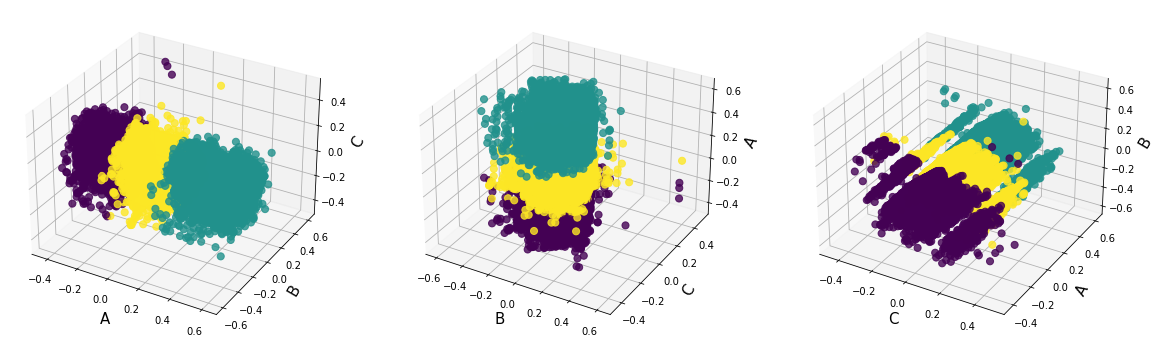

In [151]:
#Kmeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3).fit(pdf_train)
y_kmeans=km.predict(pdf)

fig = plt.figure(figsize=(20,9))
ax = fig.add_subplot(131, projection='3d')
sc = ax.scatter(pdf['A'],pdf['B'],pdf['C'],
                c=y_kmeans, s=50, alpha=0.8)
ax.set_xlabel("A", fontsize=15)
ax.set_ylabel("B", fontsize=15, rotation=60)
ax.set_zlabel("C", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

ax = fig.add_subplot(132, projection='3d')
sc = ax.scatter(pdf['B'],pdf['C'],pdf['A'],
                c=y_kmeans, s=50, alpha=0.8)
ax.set_xlabel("B", fontsize=15)
ax.set_ylabel("C", fontsize=15, rotation=60)
ax.set_zlabel("A", fontsize=15, rotation=60)
#plt.title('CoDisp above 99.5th percentile')

ax = fig.add_subplot(133, projection='3d')
sc = ax.scatter(pdf['C'],pdf['A'],pdf['B'],
                c=y_kmeans, s=50, alpha=0.8)
ax.set_xlabel("C", fontsize=15)
ax.set_ylabel("A", fontsize=15, rotation=60)
ax.set_zlabel("B", fontsize=15, rotation=60);
#plt.title('CoDisp above 99.5th percentile')

In [152]:
pdf['cluster_3'] = y_kmeans
pdf

,A,B,C,cluster_3
id,,,,
18,-0.198837,0.106100,0.010076,0
20,-0.196477,0.100427,0.016403,0
48,-0.240438,-0.116695,-0.134740,0
61,-0.169719,0.058238,-0.023430,0
62,-0.424268,0.095429,0.016496,0
...,...,...,...,...
85457,-0.403689,-0.250436,0.028491,0
85458,-0.362302,0.010451,0.197623,0
85459,-0.356147,-0.182597,0.054324,0


In [153]:
pdf = pdf.reset_index()
pdf

,id,A,B,C,cluster_3
0,18,-0.198837,0.106100,0.010076,0
1,20,-0.196477,0.100427,0.016403,0
2,48,-0.240438,-0.116695,-0.134740,0
3,61,-0.169719,0.058238,-0.023430,0
4,62,-0.424268,0.095429,0.016496,0
...,...,...,...,...,...
47651,85457,-0.403689,-0.250436,0.028491,0
47652,85458,-0.362302,0.010451,0.197623,0
47653,85459,-0.356147,-0.182597,0.054324,0
47654,85460,-0.205263,-0.133398,0.087446,0


In [165]:
pdf.head()

,id,A,B,C,cluster_3
0,18,-0.198837,0.106100,0.010076,0
1,20,-0.196477,0.100427,0.016403,0
2,48,-0.240438,-0.116695,-0.134740,0
3,61,-0.169719,0.058238,-0.023430,0
4,62,-0.424268,0.095429,0.016496,0


In [160]:
pdf['cluster_3'].notna().sum()

47656

In [166]:
df_original['residential_cluster'] = df_original.apply(lambda row: pdf[pdf['id'] == row.name]['cluster_3'].values[0] if row.name in pdf['id'].to_list() else np.nan, axis=1)

In [167]:
df_original

,year_factor,state_factor,building_class,facility_type,floor_area,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,...,building_id,energy_star_rating,peak_NE,peak_SE,peak_SW,peak_NW,max_NE,max_SE,max_SW,max_NW,facility_group,year_built,floor_area_binned,energy_intensity_floor_area,energy_intensity_built_year,energy_intensity_facility_type,mean_energy_rating_building_id,number_january,number_february,number_march,number_april,number_may,number_june,number_july,number_august,number_september,number_october,number_november,number_december,total_number,number_winter,number_spring,number_summer,number_autumn,eui_improved,eui_diff,hdd_extreme,hdd_extreme_2,avg_total_number_building,avg_eui_building,year_built_bin,yearB_E_int,calculated_eui,calc_eui_perc_off,binned_calc_eui,binned_calc_eui_20,verschil_uitstoot_per_temp_tov_jaar_state,StateYear_E_Int,commercial_cluster,residential_cluster
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,313,11.0,1,0,0,0,1,0,0,0,food_sales_service,1942.0,1,3,3,2,29.0,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,245.522877,2,3,231.720532,-0.068208,10,10,0.856815,3,1.0,NaN
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,201,45.0,0,0,0,0,1,0,0,0,distribution_shipping,1955.0,4,1,1,2,40.6,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22078.118536,27.609132,3,2,26.057054,-0.016720,1,1,-0.209475,2,2.0,NaN
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,463,97.0,0,0,0,0,1,0,0,0,retail,1951.0,4,1,1,2,97.8,1566.55555,1418.66785,1668.93785,1667.7240,1768.23175,1821.46950,1948.21145,1931.46055,1943.82435,1954.89605,1616.51970,1530.4737,20836.97230,4654.16125,5257.42525,5823.49635,5101.88945,-1,0.0,346.734908,596.734908,22068.147067,23.481589,3,2,22.171559,-0.102134,1,1,-0.218145,2,0.0,NaN
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,...,303,46.0,0,0,0,0,1,0,0,0,eduation,1980.0,1,2,2,1,49.1,1566.55555,1418.66785,1668.93785,1667.7240,1768.

In [168]:
df_original['residential_cluster'].notna().sum()

47656

In [170]:
np.nan + 2

nan

In [172]:
df_original['cluster'] = df_original.apply(lambda row: row.residential_cluster + 3 if row.residential_cluster == row.residential_cluster else row.commercial_cluster, axis=1)

In [173]:
df_original.groupby('cluster')['cluster'].count()

cluster
0.0    19361
1.0     6790
2.0    11655
3.0    16883
4.0    11402
5.0    19371
Name: cluster, dtype: int64

In [174]:
df_original.to_csv('C:/Users/Meyke/WiDS/data/features_data_3001_imputed_star_rating_and_generous_building_id.csv')